In [1]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from PIL import  Image,ImageDraw
import numpy as np
import random
import cv2
from torchvision import models
from torchsummary import summary

Batch_Size = 50
num_epochs = 200
learning_rate = 1e-5
samples = 10000

data1 = []
data2= []


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% --  Generate dataset
uframes = []
vidcap = cv2.VideoCapture('video_simple.avi')
success,image = vidcap.read()
while success:
    uframes.append(image)   
    success,image = vidcap.read()

# cap = cv2.VideoCapture('video_drone_tank.avi')


# ret, frame = cap.read()

# uframes.append(frame)
# flag = 0
# z = 0
# while(z<30):
#     ret, frame = cap.read()
#     #np_frame = cv2.imread('video', frame) # does not work
#     #np_frame = np.asarray(cv2.GetMat(frame)) # does not work
#     #print(np_frame.shape)
#     for a in uframes:
#         if (np.array(a).any() != None):
#             print("a: ",np.shape(a))
#             print("frame: ",np.shape(a))
#             difference = cv2.subtract(np.array(a), np.array(frame))    
#             result = not np.any(difference)
#             #print("inside for")
#             if result is True:
#                 flag = 1
#                 #print("setting flag")
#                 break
#     if(not flag):
#         #print("appending")
#         uframes.append(frame)
#     z+=1

for i,frame in enumerate(uframes):
    uframes[i] = cv2.resize(frame,(100,100))
    
print(np.shape(uframes[0]))

print("length: ",len(uframes))
for i in range(samples):
    data1.append(np.array(np.transpose(np.asarray(uframes[i % len(uframes)]),(2,0,1)),dtype=np.float32))
    data2.append(np.array(np.transpose(np.asarray(uframes[(i+1) % len(uframes)]),(2,0,1)),dtype=np.float32))



#%%%%%%%%%%%%%%%%%%%%%%%%%%% Noisy data
img = Image.new('RGB', (100,100), color = '#9b7653')
# img.paste(im1,(5,75),im1)
# img.paste(im1,(10,55),im1)
# img.paste(im1,(25,50),im1)
# img.paste(im2,(75,5),im2)
# img.paste(im2,(60,30),im2)
# img.paste(im2,(90,20),im2)
# img.paste(im3,(75,60),im3)
# img.paste(im3,(60,80),im3)
im_n = np.reshape(img,(100,100,3))
b = np.asarray(im_n)
b = np.array(b, dtype=np.float32)
b = np.transpose(b,(2,0,1))
b = torch.from_numpy(b)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%       

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Data Preparation

y0 = np.asarray(data1)
y1 = np.asarray(data2)

#y0 = np.array(np.transpose(np.asarray(y0),(0,3,1,2)),dtype=np.float32)
#y1 = np.array(np.transpose(np.asarray(y1),(0,3,1,2)),dtype=np.float32)
print(np.shape(y0))

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)


torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=Batch_Size,

    shuffle=True,

    num_workers=0,

)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Defining NN

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=10, stride=1)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)

#         # Convolution 2
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()

#         # Max pool 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(10368, 15)
        self.sigmoid1 = nn.Sigmoid()

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        #out = self.cnn2(out)
        #out = self.relu2(out)

        # Max pool 2 
        #out = self.maxpool2(out)
        im_out = out
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        out = self.sigmoid1(out)
        return im_out,out
    
model = CNNModel()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Loss Function

def h_score(fx, gy):
 
    fx = fx - fx.mean(0)

    gy = gy - gy.mean(0)

    Nsamples = fx.size(0)
    #print(fx, np.shape(fx))
    #print(gy, np.shape(gy))
    #print(np.shape((torch.transpose(fx,3,2))),np.shape(fx))
    covf = torch.matmul(fx.t(), fx) / Nsamples

    covg = torch.matmul(gy.t(), gy) / Nsamples

    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()

    return h


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)





for epoch in range(num_epochs):
    for x,y in loader:
        optimizer.zero_grad()
        # ===================forward=====================
        #loss = criterion(output1, img)
        loss = h_score(model(x)[1],model(y)[1])
        # ===================backward====================
 
        #optimizer_1.zero_grad()
        loss.backward()
        optimizer.step()
        #optimizer_1.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    print("shape: ", np.shape(model(x[0].reshape(1,3,100, 100))[0]))
#     print("x: ", model(x[0].reshape(1,3,100, 100)))
#     print("y:", model(y[0].reshape(1,3,100, 100)))
#     print("b:", model(b.reshape(1,3,100, 100)))


(100, 100, 3)
length:  2636
(10000, 3, 100, 100)
epoch [1/200], loss:-1.9799
shape:  torch.Size([1, 32, 18, 18])
epoch [2/200], loss:-2.8833
shape:  torch.Size([1, 32, 18, 18])
epoch [3/200], loss:-2.6622
shape:  torch.Size([1, 32, 18, 18])
epoch [4/200], loss:-2.7390
shape:  torch.Size([1, 32, 18, 18])
epoch [5/200], loss:-2.7727
shape:  torch.Size([1, 32, 18, 18])
epoch [6/200], loss:-2.8583
shape:  torch.Size([1, 32, 18, 18])
epoch [7/200], loss:-2.6980
shape:  torch.Size([1, 32, 18, 18])
epoch [8/200], loss:-2.5638
shape:  torch.Size([1, 32, 18, 18])
epoch [9/200], loss:-2.6989
shape:  torch.Size([1, 32, 18, 18])
epoch [10/200], loss:-2.7095
shape:  torch.Size([1, 32, 18, 18])
epoch [11/200], loss:-2.8849
shape:  torch.Size([1, 32, 18, 18])
epoch [12/200], loss:-3.0787
shape:  torch.Size([1, 32, 18, 18])
epoch [13/200], loss:-2.9564
shape:  torch.Size([1, 32, 18, 18])
epoch [14/200], loss:-3.1430
shape:  torch.Size([1, 32, 18, 18])
epoch [15/200], loss:-3.0868
shape:  torch.Size([1

KeyboardInterrupt: 

In [3]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_info_panel = 0
drone_info_panel = 23

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

#Blank
img = uframes[0]
z = Image.fromarray(img)
z.show()
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
output_tank = output[0][tank_info_panel]
val,pos = val_pos(output_tank)
print("Blank: ",val,pos)
output_drone = output[0][drone_info_panel]
val,pos = val_pos(output_drone)
print("Blank: ",val,pos)


#Tank

img = Image.open("frame/tank_frame0.jpg")
img =  cv2.resize(np.asarray(img),(100,100))
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
output_tank = output[0][tank_info_panel]
val,pos = val_pos(output_tank)
print("Tank: ",val,pos)
output_drone = output[0][drone_info_panel]
val,pos = val_pos(output_drone)
print("Tank: ",val,pos)


#Drone

img = Image.open("frame/frame0.jpg")
img =  cv2.resize(np.asarray(img),(100,100))
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
output_tank = output[0][tank_info_panel]
img = Image.fromarray(output)
img.show()
val,pos = val_pos(output_tank)
print("Drone: ",val,pos)
output_drone = output[0][drone_info_panel]
val,pos = val_pos(output_drone)
print("Drone: ",val,pos)


#Tank and Drone
img = uframes[10]
z = Image.fromarray(img)
z.show()
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
output_tank = output[0][tank_info_panel]
val,pos = val_pos(output_tank)
print("TD: ",val,pos)
output_drone = output[0][drone_info_panel]
val,pos = val_pos(output_drone)
print("TD: ",val,pos)



Blank:  3564.6438 (3, 2)
Blank:  3876.3477 (10, 2)
Tank:  1424.8759 (1, 0)
Tank:  17521.055 (1, 0)


TypeError: Cannot handle this data type: (1, 1, 18, 18), <f4

In [26]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

for i in range(32):

    tank_info_panel = i
    drone_info_panel = i
    #Blank
#     img = uframes[0]
#     z = Image.fromarray(img)
#     #z.show()
#     data3=[]
#     data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
#     y3 = np.array(data3)
#     x_1 = torch.from_numpy(y3)
#     output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
#     output_tank = output[0][tank_info_panel]
#     val,pos = val_pos(output_tank)
#     print("Blank: ",val,pos)
#     output_drone = output[0][drone_info_panel]
#     val,pos = val_pos(output_drone)
#     print("Blank: ",val,pos)


    
    img = Image.open("frame/tank_frame0.jpg")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Tank: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Tank: ",val,pos)


    #Drone

    img = Image.open("frame/frame0.jpg")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Drone: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Drone: ",val,pos)


    #Tank and Drone
    img = uframes[3]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("TD: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("TD: ",val,pos)
    
    print("done ",i)
    print("++++++++++++++++++++++++++++++++++++++++++++")

Tank:  904.21124 (2, 2)
Tank:  904.21124 (2, 2)
Drone:  476.2919 (11, 2)
Drone:  476.2919 (11, 2)
TD:  3254.3474 (2, 2)
TD:  3254.3474 (2, 2)
done  0
++++++++++++++++++++++++++++++++++++++++++++
Tank:  37793.29 (12, 5)
Tank:  37793.29 (12, 5)
Drone:  37964.766 (10, 1)
Drone:  37964.766 (10, 1)
TD:  3461.4346 (2, 3)
TD:  3461.4346 (2, 3)
done  1
++++++++++++++++++++++++++++++++++++++++++++
Tank:  34537.508 (8, 10)
Tank:  34537.508 (8, 10)
Drone:  34666.51 (8, 10)
Drone:  34666.51 (8, 10)
TD:  5049.704 (2, 4)
TD:  5049.704 (2, 4)
done  2
++++++++++++++++++++++++++++++++++++++++++++
Tank:  14608.957 (2, 1)
Tank:  14608.957 (2, 1)
Drone:  14441.087 (12, 12)
Drone:  14441.087 (12, 12)
TD:  3423.6873 (1, 3)
TD:  3423.6873 (1, 3)
done  3
++++++++++++++++++++++++++++++++++++++++++++
Tank:  37453.734 (0, 0)
Tank:  37453.734 (0, 0)
Drone:  37540.715 (15, 5)
Drone:  37540.715 (15, 5)
TD:  5123.626 (9, 2)
TD:  5123.626 (9, 2)
done  4
++++++++++++++++++++++++++++++++++++++++++++
Tank:  304.40347 (2

In [49]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_info_panel = 0
drone_info_panel = 12

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position
tank_co_ordinates=[]
drone_coordinates=[]
#Blank

for i in range(50):
    img = uframes[i]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_tank,pos_tank = val_pos(output_tank)
    print(i)
    output_drone = output[0][drone_info_panel]
    val_drone,pos_drone = val_pos(output_drone)
    if val_tank>850:
        print("tank present")
        print("Tank info: ",val_tank,pos_tank)
        tank_co_ordinates.append(pos_tank)
    if val_drone>3700:
        print("drone present")
        print("Drone info: ",val_drone,pos_drone)
        drone_coordinates.append(pos_drone)
    

0
tank present
Tank info:  3263.7158 (2, 0)
drone present
Drone info:  4359.7285 (1, 1)
1
tank present
Tank info:  3255.3481 (2, 0)
drone present
Drone info:  4344.051 (1, 1)
2
tank present
Tank info:  3251.8965 (2, 0)
drone present
Drone info:  4340.652 (1, 1)
3
tank present
Tank info:  3254.3474 (2, 2)
drone present
Drone info:  4332.813 (2, 4)
4
tank present
Tank info:  3243.772 (2, 2)
drone present
Drone info:  4335.5005 (2, 4)
5
tank present
Tank info:  3119.0356 (2, 4)
drone present
Drone info:  4248.6846 (1, 4)
6
tank present
Tank info:  3122.6584 (2, 4)
drone present
Drone info:  4253.6504 (1, 4)
7
tank present
Tank info:  3118.8193 (2, 4)
drone present
Drone info:  4250.754 (1, 4)
8
tank present
Tank info:  3172.2397 (2, 5)
drone present
Drone info:  4196.17 (1, 6)
9
tank present
Tank info:  3171.974 (2, 5)
drone present
Drone info:  4190.316 (1, 6)
10
tank present
Tank info:  2604.5034 (2, 7)
11
tank present
Tank info:  2602.4287 (2, 7)
12
tank present
Tank info:  2603.3447 (

In [44]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import numpy as np
import matplotlib.pyplot as plt
tank_info_panel = 0
drone_info_panel = 12

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position
tank_co_ordinates=[]
drone_coordinates=[]
#Blank
for j in range(32):
    print("++++++++++++++++++++++++++++channel "+str(j))
    drone_info_panel = j
    for i in range(50):
        img = uframes[i]
        z = Image.fromarray(img)
        #z.show()
        data3=[]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
        output_tank = output[0][tank_info_panel]
        val_tank,pos_tank = val_pos(output_tank)
        print(i)
        output_drone = output[0][drone_info_panel]
        val_drone,pos_drone = val_pos(output_drone)
        if val_tank>850:
            print("tank present")
            print("Tank info: ",val_tank,pos_tank)
            tank_co_ordinates.append(pos_tank)
        if val_drone>770:
            print("drone present")
            print("Drone info: ",val_drone,pos_drone)
            drone_coordinates.append(pos_drone)


++++++++++++++++++++++++++++channel 0
0
tank present
Tank info:  3263.7158 (2, 0)
drone present
Drone info:  3263.7158 (2, 0)
1
tank present
Tank info:  3255.3481 (2, 0)
drone present
Drone info:  3255.3481 (2, 0)
2
tank present
Tank info:  3251.8965 (2, 0)
drone present
Drone info:  3251.8965 (2, 0)
3
tank present
Tank info:  3254.3474 (2, 2)
drone present
Drone info:  3254.3474 (2, 2)
4
tank present
Tank info:  3243.772 (2, 2)
drone present
Drone info:  3243.772 (2, 2)
5
tank present
Tank info:  3119.0356 (2, 4)
drone present
Drone info:  3119.0356 (2, 4)
6
tank present
Tank info:  3122.6584 (2, 4)
drone present
Drone info:  3122.6584 (2, 4)
7
tank present
Tank info:  3118.8193 (2, 4)
drone present
Drone info:  3118.8193 (2, 4)
8
tank present
Tank info:  3172.2397 (2, 5)
drone present
Drone info:  3172.2397 (2, 5)
9
tank present
Tank info:  3171.974 (2, 5)
drone present
Drone info:  3171.974 (2, 5)
10
tank present
Tank info:  2604.5034 (2, 7)
drone present
Drone info:  2604.5034 (2, 

9
tank present
Tank info:  3171.974 (2, 5)
drone present
Drone info:  4817.6025 (8, 1)
10
tank present
Tank info:  2604.5034 (2, 7)
drone present
Drone info:  3947.872 (2, 8)
11
tank present
Tank info:  2602.4287 (2, 7)
drone present
Drone info:  3950.2131 (2, 8)
12
tank present
Tank info:  2603.3447 (2, 7)
drone present
Drone info:  3947.6633 (2, 8)
13
tank present
Tank info:  2170.9531 (2, 8)
drone present
Drone info:  4044.6038 (2, 9)
14
tank present
Tank info:  2169.2837 (2, 8)
drone present
Drone info:  4045.1465 (2, 9)
15
tank present
Tank info:  2389.0605 (2, 9)
drone present
Drone info:  4050.7295 (2, 10)
16
tank present
Tank info:  2379.6528 (2, 9)
drone present
Drone info:  4051.4492 (2, 10)
17
tank present
Tank info:  2386.7407 (2, 9)
drone present
Drone info:  4044.9404 (2, 10)
18
tank present
Tank info:  2514.0054 (2, 9)
drone present
Drone info:  4127.3413 (2, 11)
19
tank present
Tank info:  2517.0684 (2, 9)
drone present
Drone info:  4122.7847 (2, 11)
20
tank present
Tan

33
tank present
Tank info:  2509.0554 (2, 14)
drone present
Drone info:  3731.2305 (2, 15)
34
tank present
Tank info:  2478.9502 (2, 15)
drone present
Drone info:  3794.4128 (2, 16)
35
tank present
Tank info:  2476.7898 (2, 15)
drone present
Drone info:  3795.1467 (2, 16)
36
tank present
Tank info:  2525.3958 (2, 15)
drone present
Drone info:  3726.6282 (2, 17)
37
tank present
Tank info:  2534.1592 (2, 15)
drone present
Drone info:  3731.1387 (2, 17)
38
tank present
Tank info:  2529.3286 (2, 15)
drone present
Drone info:  3727.7068 (2, 17)
39
tank present
Tank info:  2514.7603 (2, 15)
drone present
Drone info:  3679.4717 (2, 17)
40
tank present
Tank info:  2525.9302 (2, 15)
drone present
Drone info:  3944.27 (2, 16)
41
tank present
Tank info:  2525.2668 (2, 15)
drone present
Drone info:  3947.7498 (2, 16)
42
tank present
Tank info:  2527.2446 (2, 15)
drone present
Drone info:  3952.979 (2, 16)
43
tank present
Tank info:  2626.4578 (2, 14)
drone present
Drone info:  3903.6628 (2, 15)
44

8
tank present
Tank info:  3172.2397 (2, 5)
drone present
Drone info:  2445.501 (10, 1)
9
tank present
Tank info:  3171.974 (2, 5)
drone present
Drone info:  2440.4902 (10, 1)
10
tank present
Tank info:  2604.5034 (2, 7)
drone present
Drone info:  2029.2961 (3, 7)
11
tank present
Tank info:  2602.4287 (2, 7)
drone present
Drone info:  2028.9893 (3, 7)
12
tank present
Tank info:  2603.3447 (2, 7)
drone present
Drone info:  2026.9287 (3, 7)
13
tank present
Tank info:  2170.9531 (2, 8)
drone present
Drone info:  1569.4818 (3, 8)
14
tank present
Tank info:  2169.2837 (2, 8)
drone present
Drone info:  1572.4141 (3, 8)
15
tank present
Tank info:  2389.0605 (2, 9)
drone present
Drone info:  1599.2814 (11, 3)
16
tank present
Tank info:  2379.6528 (2, 9)
drone present
Drone info:  1592.3884 (11, 3)
17
tank present
Tank info:  2386.7407 (2, 9)
drone present
Drone info:  1595.7073 (11, 3)
18
tank present
Tank info:  2514.0054 (2, 9)
drone present
Drone info:  1711.5452 (3, 10)
19
tank present
Tan

21
tank present
Tank info:  2555.492 (2, 10)
drone present
Drone info:  2434.4482 (2, 11)
22
tank present
Tank info:  2549.0264 (2, 11)
drone present
Drone info:  2547.1743 (1, 11)
23
tank present
Tank info:  2547.882 (2, 11)
drone present
Drone info:  2546.8076 (1, 11)
24
tank present
Tank info:  2554.837 (2, 12)
drone present
Drone info:  2546.1006 (2, 12)
25
tank present
Tank info:  2552.949 (2, 12)
drone present
Drone info:  2542.9844 (2, 12)
26
tank present
Tank info:  2599.21 (2, 12)
drone present
Drone info:  2464.6382 (2, 13)
27
tank present
Tank info:  2595.0532 (2, 12)
drone present
Drone info:  2461.1782 (2, 13)
28
tank present
Tank info:  2488.4773 (2, 13)
drone present
Drone info:  2490.768 (2, 13)
29
tank present
Tank info:  2485.9155 (2, 13)
drone present
Drone info:  2494.2515 (2, 13)
30
tank present
Tank info:  2560.468 (2, 14)
drone present
Drone info:  2537.4224 (2, 14)
31
tank present
Tank info:  2553.5896 (2, 14)
drone present
Drone info:  2543.3613 (2, 14)
32
tank

Drone info:  2136.247 (11, 13)
41
tank present
Tank info:  2525.2668 (2, 15)
drone present
Drone info:  2136.5151 (11, 13)
42
tank present
Tank info:  2527.2446 (2, 15)
drone present
Drone info:  2133.2146 (11, 13)
43
tank present
Tank info:  2626.4578 (2, 14)
drone present
Drone info:  2164.9302 (11, 13)
44
tank present
Tank info:  2626.1694 (2, 14)
drone present
Drone info:  2171.979 (11, 13)
45
tank present
Tank info:  2594.4016 (2, 14)
drone present
Drone info:  2222.466 (11, 13)
46
tank present
Tank info:  2596.7107 (2, 14)
drone present
Drone info:  2222.5522 (11, 13)
47
tank present
Tank info:  2593.9368 (2, 14)
drone present
Drone info:  2221.6128 (11, 13)
48
tank present
Tank info:  2571.8374 (2, 13)
drone present
Drone info:  2245.176 (11, 13)
49
tank present
Tank info:  2565.2632 (2, 13)
drone present
Drone info:  2242.748 (11, 13)
++++++++++++++++++++++++++++channel 12
0
tank present
Tank info:  3263.7158 (2, 0)
drone present
Drone info:  4359.7285 (1, 1)
1
tank present
Tan

Tank info:  2604.5034 (2, 7)
drone present
Drone info:  2392.2356 (1, 9)
11
tank present
Tank info:  2602.4287 (2, 7)
drone present
Drone info:  2394.3442 (1, 9)
12
tank present
Tank info:  2603.3447 (2, 7)
drone present
Drone info:  2393.381 (1, 9)
13
tank present
Tank info:  2170.9531 (2, 8)
drone present
Drone info:  1967.803 (1, 9)
14
tank present
Tank info:  2169.2837 (2, 8)
drone present
Drone info:  1966.8342 (1, 9)
15
tank present
Tank info:  2389.0605 (2, 9)
drone present
Drone info:  2122.024 (1, 9)
16
tank present
Tank info:  2379.6528 (2, 9)
drone present
Drone info:  2108.04 (1, 9)
17
tank present
Tank info:  2386.7407 (2, 9)
drone present
Drone info:  2114.502 (1, 9)
18
tank present
Tank info:  2514.0054 (2, 9)
drone present
Drone info:  2102.0022 (2, 10)
19
tank present
Tank info:  2517.0684 (2, 9)
drone present
Drone info:  2100.415 (2, 10)
20
tank present
Tank info:  2553.277 (2, 10)
drone present
Drone info:  2225.9468 (1, 12)
21
tank present
Tank info:  2555.492 (2, 

31
tank present
Tank info:  2553.5896 (2, 14)
drone present
Drone info:  2995.5127 (2, 14)
32
tank present
Tank info:  2513.6533 (2, 14)
drone present
Drone info:  2911.0889 (3, 16)
33
tank present
Tank info:  2509.0554 (2, 14)
drone present
Drone info:  2906.4766 (3, 16)
34
tank present
Tank info:  2478.9502 (2, 15)
drone present
Drone info:  2798.359 (3, 16)
35
tank present
Tank info:  2476.7898 (2, 15)
drone present
Drone info:  2794.5146 (3, 16)
36
tank present
Tank info:  2525.3958 (2, 15)
drone present
Drone info:  2839.0647 (3, 17)
37
tank present
Tank info:  2534.1592 (2, 15)
drone present
Drone info:  2834.4985 (3, 17)
38
tank present
Tank info:  2529.3286 (2, 15)
drone present
Drone info:  2830.1055 (3, 17)
39
tank present
Tank info:  2514.7603 (2, 15)
drone present
Drone info:  2829.5068 (3, 17)
40
tank present
Tank info:  2525.9302 (2, 15)
drone present
Drone info:  2890.9688 (3, 16)
41
tank present
Tank info:  2525.2668 (2, 15)
drone present
Drone info:  2893.4922 (3, 16)


0
tank present
Tank info:  3263.7158 (2, 0)
drone present
Drone info:  3047.529 (1, 13)
1
tank present
Tank info:  3255.3481 (2, 0)
drone present
Drone info:  3017.8179 (1, 13)
2
tank present
Tank info:  3251.8965 (2, 0)
drone present
Drone info:  3018.288 (1, 13)
3
tank present
Tank info:  3254.3474 (2, 2)
drone present
Drone info:  3003.0046 (1, 13)
4
tank present
Tank info:  3243.772 (2, 2)
drone present
Drone info:  3009.4092 (1, 13)
5
tank present
Tank info:  3119.0356 (2, 4)
drone present
Drone info:  2912.9036 (1, 13)
6
tank present
Tank info:  3122.6584 (2, 4)
drone present
Drone info:  2912.0972 (1, 13)
7
tank present
Tank info:  3118.8193 (2, 4)
drone present
Drone info:  2909.578 (1, 13)
8
tank present
Tank info:  3172.2397 (2, 5)
drone present
Drone info:  2953.2832 (1, 13)
9
tank present
Tank info:  3171.974 (2, 5)
drone present
Drone info:  2957.8684 (1, 13)
10
tank present
Tank info:  2604.5034 (2, 7)
drone present
Drone info:  2511.19 (1, 13)
11
tank present
Tank info: 

21
tank present
Tank info:  2555.492 (2, 10)
drone present
Drone info:  3593.144 (2, 10)
22
tank present
Tank info:  2549.0264 (2, 11)
drone present
Drone info:  3687.4639 (2, 11)
23
tank present
Tank info:  2547.882 (2, 11)
drone present
Drone info:  3683.2388 (2, 11)
24
tank present
Tank info:  2554.837 (2, 12)
drone present
Drone info:  3657.1987 (2, 13)
25
tank present
Tank info:  2552.949 (2, 12)
drone present
Drone info:  3661.8828 (2, 13)
26
tank present
Tank info:  2599.21 (2, 12)
drone present
Drone info:  3658.9165 (2, 13)
27
tank present
Tank info:  2595.0532 (2, 12)
drone present
Drone info:  3656.3413 (2, 13)
28
tank present
Tank info:  2488.4773 (2, 13)
drone present
Drone info:  3618.584 (2, 14)
29
tank present
Tank info:  2485.9155 (2, 13)
drone present
Drone info:  3619.9038 (2, 14)
30
tank present
Tank info:  2560.468 (2, 14)
drone present
Drone info:  3634.6348 (2, 15)
31
tank present
Tank info:  2553.5896 (2, 14)
drone present
Drone info:  3635.9883 (2, 15)
32
tank 

38
tank present
Tank info:  2529.3286 (2, 15)
drone present
Drone info:  2307.045 (10, 2)
39
tank present
Tank info:  2514.7603 (2, 15)
drone present
Drone info:  2260.4263 (10, 2)
40
tank present
Tank info:  2525.9302 (2, 15)
drone present
Drone info:  2468.6396 (10, 3)
41
tank present
Tank info:  2525.2668 (2, 15)
drone present
Drone info:  2464.7002 (17, 14)
42
tank present
Tank info:  2527.2446 (2, 15)
drone present
Drone info:  2458.7913 (10, 3)
43
tank present
Tank info:  2626.4578 (2, 14)
drone present
Drone info:  2429.2012 (17, 14)
44
tank present
Tank info:  2626.1694 (2, 14)
drone present
Drone info:  2434.755 (17, 14)
45
tank present
Tank info:  2594.4016 (2, 14)
drone present
Drone info:  2434.6094 (10, 3)
46
tank present
Tank info:  2596.7107 (2, 14)
drone present
Drone info:  2436.618 (10, 3)
47
tank present
Tank info:  2593.9368 (2, 14)
drone present
Drone info:  2437.2893 (10, 3)
48
tank present
Tank info:  2571.8374 (2, 13)
drone present
Drone info:  2447.1423 (10, 3)

49
tank present
Tank info:  2565.2632 (2, 13)
drone present
Drone info:  3148.3745 (11, 12)
++++++++++++++++++++++++++++channel 26
0
tank present
Tank info:  3263.7158 (2, 0)
drone present
Drone info:  3493.3257 (2, 2)
1
tank present
Tank info:  3255.3481 (2, 0)
drone present
Drone info:  3474.5117 (2, 2)
2
tank present
Tank info:  3251.8965 (2, 0)
drone present
Drone info:  3476.9883 (2, 2)
3
tank present
Tank info:  3254.3474 (2, 2)
drone present
Drone info:  3399.5957 (3, 4)
4
tank present
Tank info:  3243.772 (2, 2)
drone present
Drone info:  3399.3179 (3, 4)
5
tank present
Tank info:  3119.0356 (2, 4)
drone present
Drone info:  3362.7456 (2, 5)
6
tank present
Tank info:  3122.6584 (2, 4)
drone present
Drone info:  3356.2266 (2, 5)
7
tank present
Tank info:  3118.8193 (2, 4)
drone present
Drone info:  3356.6494 (2, 5)
8
tank present
Tank info:  3172.2397 (2, 5)
drone present
Drone info:  3339.7349 (2, 8)
9
tank present
Tank info:  3171.974 (2, 5)
drone present
Drone info:  3333.729

18
tank present
Tank info:  2514.0054 (2, 9)
drone present
Drone info:  2711.2402 (2, 10)
19
tank present
Tank info:  2517.0684 (2, 9)
drone present
Drone info:  2712.1077 (2, 10)
20
tank present
Tank info:  2553.277 (2, 10)
drone present
Drone info:  2746.2363 (13, 6)
21
tank present
Tank info:  2555.492 (2, 10)
drone present
Drone info:  2754.8389 (13, 6)
22
tank present
Tank info:  2549.0264 (2, 11)
drone present
Drone info:  2848.832 (2, 11)
23
tank present
Tank info:  2547.882 (2, 11)
drone present
Drone info:  2846.8115 (2, 11)
24
tank present
Tank info:  2554.837 (2, 12)
drone present
Drone info:  2893.9497 (2, 12)
25
tank present
Tank info:  2552.949 (2, 12)
drone present
Drone info:  2888.4712 (2, 12)
26
tank present
Tank info:  2599.21 (2, 12)
drone present
Drone info:  2828.6692 (13, 6)
27
tank present
Tank info:  2595.0532 (2, 12)
drone present
Drone info:  2826.582 (13, 6)
28
tank present
Tank info:  2488.4773 (2, 13)
drone present
Drone info:  2796.2878 (10, 3)
29
tank pr

Drone info:  1695.0447 (3, 16)
41
tank present
Tank info:  2525.2668 (2, 15)
drone present
Drone info:  1697.3773 (3, 16)
42
tank present
Tank info:  2527.2446 (2, 15)
drone present
Drone info:  1699.322 (3, 16)
43
tank present
Tank info:  2626.4578 (2, 14)
drone present
Drone info:  1766.228 (3, 16)
44
tank present
Tank info:  2626.1694 (2, 14)
drone present
Drone info:  1768.1058 (3, 16)
45
tank present
Tank info:  2594.4016 (2, 14)
drone present
Drone info:  1774.5278 (3, 15)
46
tank present
Tank info:  2596.7107 (2, 14)
drone present
Drone info:  1776.0681 (3, 15)
47
tank present
Tank info:  2593.9368 (2, 14)
drone present
Drone info:  1775.9359 (3, 15)
48
tank present
Tank info:  2571.8374 (2, 13)
drone present
Drone info:  1685.1417 (3, 15)
49
tank present
Tank info:  2565.2632 (2, 13)
drone present
Drone info:  1683.6997 (3, 15)
++++++++++++++++++++++++++++channel 31
0
tank present
Tank info:  3263.7158 (2, 0)
drone present
Drone info:  3183.0952 (10, 2)
1
tank present
Tank info

In [15]:
im1 = Image.open('tree1.png')
im1 = im1.resize((100,100))

imt = Image.open('tank.png')
imt = imt.resize((100,100))


im2 = Image.open('tree2.png')
im2 = im2.resize((100,100))

im3 = Image.open('tree3.png')
im3 = im3.resize((100,100))

im_drone = Image.open('drone4-1.png')
im_drone = im_drone.resize((200,200))

imb = Image.open('bullet.png')
imb = imb.resize((40,40))



img_blank = Image.new('RGB', (720, 1080), color = '#9b7653')
img_blank.paste(im1,(5,75),im1)
img_blank.paste(im1,(450,550),im1)
img_blank.paste(im1,(205,720),im1)
img_blank.paste(im2,(500,900),im2)
img_blank.paste(im2,(650,750),im2)
img_blank.paste(im2,(320,440),im2)
img_blank.paste(im3,(100,600),im3)
img_blank.paste(im3,(440,620),im3)
img_blank.paste(im3,(300,150),im3)
img_blank.paste(imt.rotate(180),(500,500),imt.rotate(180))
img_blank = np.asarray(img_blank)
img_blank = cv2.resize(img_blank,(100,100))
pil = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
pil = torch.from_numpy(pil)
output = model(pil.reshape(1,3,100, 100))[0].detach().numpy()
output = output[0][info_panel]
val,pos = val_pos(output)
print(val,pos)

NameError: name 'info_panel' is not defined

In [3]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

for i in range(12):
    k = uframes[i]
    #k.show()
    v = np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32)
    v = torch.from_numpy(v)
    filename = "Marginalization_Simple-increased_channels-32/ref_image_new_" + str(i) + ".txt"
    file = open(filename, 'w')
    file.write(str(model(v.reshape(1,3,100, 100))[0].detach().numpy()))
    file.close()


In [22]:
img = uframes[0]
img = Image.fromarray(img)
img.show()


In [4]:
##Weights

import operator
k=model.fc1.weight.detach().numpy()
for i in range(15):
    index, value = max(enumerate(k[i]), key=operator.itemgetter(1))
    print("FC - Feature "+ "i: ",index,value)
    print("CNN value: ", )

FC - Feature i:  684 0.041578084
CNN value: 
FC - Feature i:  684 0.051804464
CNN value: 
FC - Feature i:  360 0.04816093
CNN value: 
FC - Feature i:  492 0.035558272
CNN value: 
FC - Feature i:  478 0.06459166
CNN value: 
FC - Feature i:  585 0.049136233
CNN value: 
FC - Feature i:  492 0.081621096
CNN value: 
FC - Feature i:  360 0.065480515
CNN value: 
FC - Feature i:  585 0.04792851
CNN value: 
FC - Feature i:  492 0.06556648
CNN value: 
FC - Feature i:  684 0.035789683
CNN value: 
FC - Feature i:  684 0.034514345
CNN value: 
FC - Feature i:  817 0.043642323
CNN value: 
FC - Feature i:  492 0.088237286
CNN value: 
FC - Feature i:  492 0.09752004
CNN value: 


In [6]:
import operator
import sys
#t1d1
img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(imt.rotate(180),(10,30),imt.rotate(180))
# img_blank.paste(im_drone.resize((10,10)),(2,10),im_drone.resize((10,10)))

# #t2d2
# img_blank.paste(imt.rotate(180),(30,30),imt.rotate(180))
# draw = ImageDraw.Draw(img_blank)
# draw.ellipse((35,35,38,38), fill=(255, 0, 0))
# img_blank.paste(im_drone.resize((10,10)),(35,45),im_drone.resize((10,10)))
# draw.ellipse((40,50,43,53), fill=(50, 182, 150))

# #t3d3
# img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
# img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
# img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
# img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

v = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
v = torch.from_numpy(v)
k = model(v.reshape(1,3,100, 100))[0].view(model(v.reshape(1,3,100, 100))[0].size(0), -1).detach().numpy()

filename = "Marginalization_Simple/flattened_tank_pos_1.txt"
file = open(filename, 'w')
file.write(str(k))
file.close()


# print(np.shape(k))
# index, value = max(enumerate(k), key=operator.itemgetter(1))
# print(index,value)


import operator
p=model.fc1.weight.detach().numpy()
for i in range(15):
    index, value = max(enumerate(p[i]), key=operator.itemgetter(1))
    print("FC - Feature "+ str(i) +" : ",index,value)
    print
    print("CNN value: ",k[0][index] )

FC - Feature 0 :  684 0.041578084
CNN value:  17.59211
FC - Feature 1 :  684 0.051804464
CNN value:  17.59211
FC - Feature 2 :  360 0.04816093
CNN value:  0.53643996
FC - Feature 3 :  492 0.035558272
CNN value:  0.53643996
FC - Feature 4 :  478 0.06459166
CNN value:  0.53643996
FC - Feature 5 :  585 0.049136233
CNN value:  0.53643996
FC - Feature 6 :  492 0.081621096
CNN value:  0.53643996
FC - Feature 7 :  360 0.065480515
CNN value:  0.53643996
FC - Feature 8 :  585 0.04792851
CNN value:  0.53643996
FC - Feature 9 :  492 0.06556648
CNN value:  0.53643996
FC - Feature 10 :  684 0.035789683
CNN value:  17.59211
FC - Feature 11 :  684 0.034514345
CNN value:  17.59211
FC - Feature 12 :  817 0.043642323
CNN value:  17.59211
FC - Feature 13 :  492 0.088237286
CNN value:  0.53643996
FC - Feature 14 :  492 0.09752004
CNN value:  0.53643996


In [21]:

import random


p=0
class_data = []
while(p<len(uframes)):
    data3=[]
    print(p)
    for i in range(50):
        img = uframes[p]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        temp = model(x_1[i].reshape(1,3,100,100))[1]
        #print(temp)
        class_data.append((list(temp.detach().numpy()[0]),p))
    p+=1
    print(len(class_data))

random.shuffle(class_data)
random.shuffle(class_data)

print("length ", len(class_data))

0
50
1
100
2
150
3
200
4
250
5
300
6
350
7
400
8
450
9
500
10
550
11
600
length  600


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from colorama import init  
import time
import cv2

print(np.shape(uframes[0]))


#z  = np.array(np.transpose(np.asarray(z),(2,0,1)),dtype=np.float32)
# import some data to play with
print("Length of Class data: ", len(class_data))
# Take the first two features. We could avoid this by using a two-dim dataset
X = [(i[0]) for i in class_data]
y = [i[1] for i in class_data]
#print(X,np.shape(X))
#print(y,np.shape(y))
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel='linear', C=C)
clf = clf.fit(X, y)
data3=[]
y3=0

n1 = "\x1b[31m\"Drone Stationary, Tank Firing\"\x1b[0m"
n2 = "\x1b[31m\"Drone Reloading, Tank Firing\"\x1b[0m"
n3 = "\x1b[31m\"Drone Firing, Tank Stationary\"\x1b[0m"
n4 = "\x1b[31m\"Drone Firing, Tank Reloading\"\x1b[0m"
n5 = "\x1b[31m\"Drone Firing, Tank Firing\"\x1b[0m"

names = ['Just Background','Only Tank moving', 'Only Drone Moving', 'Drone stationary, Tank Stationary', 'Drone Stationary, Tank Reloading' ,
         n1, 'Drone reloading, Tank Stationary', 'Drone reloading, Tank Reloading', n2 , n3,n4,n5]

print("Start")

img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(im1,(5,7),im1)
img_blank.paste(im1,(45,55),im1)
img_blank.paste(im1,(25,72),im1)
img_blank.paste(im2,(50,90),im2)
img_blank.paste(im2,(60,75),im2)
img_blank.paste(im2,(30,40),im2)
img_blank.paste(im3,(10,60),im3)
img_blank.paste(im3,(44,62),im3)
img_blank.paste(im3,(30,15),im3)
img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
#img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
#img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

for i in range(12):
    #z = cv2.imread('Images_100/0a.png')
    #l = Image.fromarray(z)
#     print("shape of z", np.shape(z),type(z))
#     #l.show()
#     #z  = cv2.resize(z,(100,100))
#     img = uframes[i]
#     print(np.shape(img))
#     img.show()
#     data3.append(np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32))
#     y3 = np.array(data3)
#     x_1 = torch.from_numpy(y3)
# #     random_img = random.choice(x)
# #     print("random", np.shape(random_img),type(random_img))
# #     show = random_img.detach().numpy() * 255
# #     show = np.array(np.transpose(show,(1,2,0)),dtype=np.uint8)
# #     print("show", np.shape(show),type(show))
# #     ms = Image.fromarray(show)
# #     ms.show()
#     temp = model(x_1[i].reshape(1,3,100,100))[1]
#     temp = temp.detach().numpy()
#     img_blank.show()
#     #print(temp)
#     z = clf.predict(temp)
#     print(names[z[0]])
    img = uframes[i]
    print(np.shape(img))
    img.show()
    #ms = Image.fromarray(z)
    #ms.show()
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    temp = model(x_1[i].reshape(1,3,100,100))[1]
    temp = temp.detach().numpy()
    print(temp)
    z = clf.predict(temp)
    print(names[z[0]])
    
    

(100, 100, 3)
Length of Class data:  600
Start
(100, 100, 3)
[[5.69654167e-01 9.99462187e-01 5.63863292e-02 4.24214751e-01
  9.99946237e-01 3.76719624e-01 9.24754981e-03 9.96866763e-01
  3.24720666e-02 6.23485744e-01 9.99366581e-01 1.33173708e-05
  9.99919176e-01 1.10880566e-04 7.16020440e-05]]
Just Background
(100, 100, 3)
[[1.0693459e-01 9.7853309e-01 6.2482929e-01 8.8721722e-01 9.2732191e-01
  3.8686104e-04 4.0334295e-03 9.7163016e-01 4.2039016e-01 9.9970645e-01
  9.6105587e-01 4.5536429e-02 9.1955161e-01 2.7226047e-03 7.8407951e-02]]
Only Tank moving
(100, 100, 3)
[[7.3534204e-03 9.9773276e-01 9.8508829e-01 9.9262118e-01 4.5104271e-01
  3.5262175e-04 1.2917872e-04 7.4658793e-01 9.1725689e-01 9.9936992e-01
  9.9860114e-01 5.1300049e-01 5.2829486e-01 2.9081654e-02 4.6734187e-01]]
Only Drone Moving
(100, 100, 3)
[[6.6964526e-04 9.1521192e-01 9.9945718e-01 9.9930429e-01 5.6288450e-04
  2.2586556e-07 5.6052031e-05 2.4077968e-01 9.9584311e-01 9.9999964e-01
  9.1780317e-01 9.9973506e-01 1

In [66]:
print(len(uframes
         ))

12


In [44]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(im1,(5,7),im1)
img_blank.paste(im1,(45,55),im1)
img_blank.paste(im1,(25,72),im1)
img_blank.paste(im2,(50,90),im2)
img_blank.paste(im2,(60,75),im2)
img_blank.paste(im2,(30,40),im2)
img_blank.paste(im3,(10,60),im3)
img_blank.paste(im3,(44,62),im3)
img_blank.paste(im3,(30,15),im3)
img_blank.paste(imt.rotate(180),(60,60),imt.rotate(180))
#img_blank.paste(im_drone.resize((10,10)),(10,30),im_drone.resize((10,10)))
#img_blank.paste(imt.rotate(180),(30,30),imt.rotate(180))
#draw = ImageDraw.Draw(img_blank)
#draw.ellipse((60,60,68,68), fill=(255, 0, 0))
# img_blank.paste(im_drone.resize((10,10)),(35,45),im_drone.resize((10,10)))
#draw = ImageDraw.Draw(img_blank)
#draw.ellipse((10,30,18,38), fill=(50, 182, 150))
#img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
#img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
#img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
#img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))
img_blank.show()
pil = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
pil = torch.from_numpy(pil)
filename = "lesser_15_features/testing.txt"
file = open(filename, 'w')
file.write(str(model(pil.reshape(1,3,100, 100))[0].detach().numpy()))
file.close()

In [9]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
#img_blank.paste(imt.rotate(180),(30,30),imt.rotate(180))
#img_blank.paste(im_drone.resize((10,10)),(35,45),im_drone.resize((10,10)))

#img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))

pil = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
pil = torch.from_numpy(pil)
filename = "Marginalization_Simple-increased_channels-32/drone_pos_3.txt"
file = open(filename, 'w')
file.write(str(model(pil.reshape(1,3,100, 100))[0].detach().numpy()))
file.close()

In [4]:
import cv2
vidcap = cv2.VideoCapture('tank.avi')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame/tank_frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

[(2, 0), (2, 0), (2, 0), (2, 2), (2, 2), (2, 4), (2, 4), (2, 4), (2, 5), (2, 5), (2, 7), (2, 7), (2, 7), (2, 8), (2, 8), (2, 9), (2, 9), (2, 9), (2, 9), (2, 9), (2, 10), (2, 10), (2, 11), (2, 11), (2, 12), (2, 12), (2, 12), (2, 12), (2, 13), (2, 13), (2, 14), (2, 14), (2, 14), (2, 14), (2, 15), (2, 15), (2, 15), (2, 15), (2, 15), (2, 15), (2, 15), (2, 15), (2, 15), (2, 14), (2, 14), (2, 14), (2, 14), (2, 14), (2, 13), (2, 13)]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] [0, 0, 0, 2, 2, 4, 4, 4, 5, 5, 7, 7, 7, 8, 8, 9, 9, 9, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 13, 13]


<function matplotlib.pyplot.show(*args, **kw)>

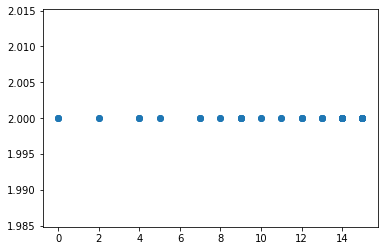

In [34]:
import numpy as np
import matplotlib.pyplot as plt
print(tank_co_ordinates)
x = [tank_co_ordinates[i][0] for i in range(len(tank_co_ordinates))]
y = [tank_co_ordinates[i][1] for i in range(len(tank_co_ordinates))]
print(x,y)
plt.scatter(y,x)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

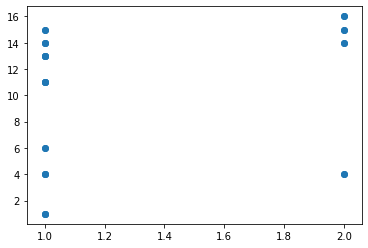

In [50]:
import numpy as np
import matplotlib.pyplot as plt
x = [drone_coordinates[i][0] for i in range(len(drone_coordinates))]
y = [drone_coordinates[i][1] for i in range(len(drone_coordinates))]
plt.scatter(x,y)
plt.show

In [14]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)   

from PIL import  Image,ImageDraw

img = Image.open("frame/tank_frame0.jpg")
img =  cv2.resize(np.asarray(img),(100,100))
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
temp = model(x_1[0].reshape(1,3,100,100))[0].detach().numpy()
filename = "Marginalization_Simple-increased_channels-32-video-multiple/tank.txt"
file = open(filename, 'w')
file.write(str(model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()))
file.close()